# EfficientNetV2B3 improved

## Description

**Codabench accuracy** : 0.84

**Local test accuracy**: 0.98

**Description**: we use EfficientNetV2B3 with:
1. Augmentation is now done exclusively outside the network
2. Using Augmented Data even in validation and testing

This is even better on test than the previous EfficientNetB0 (which was the highest so far), and has a high accuracy on validation data, which is augmented, meaning that is theoretically more robust in general


Exploiting pretrained feature extractors simplifies training and improves generalization capability, according to the architecture used

**Motivation**: trying to classify more accurately augmented images by hyperparameter tuning.





## Google Drive - Connecting to the project

In [3]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1


## Imports

In [4]:
%load_ext autoreload
%autoreload 2
!pip install keras_cv

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import keras_cv
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetV2B3
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#from tensorflow.keras import mixed_precision

In [5]:
#policy = mixed_precision.Policy('mixed_float32')
#mixed_precision.set_global_policy(policy)

## Parameters

In [6]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)
BATCH_SIZE = 64

## Load Data

In [7]:
# Parameters used for loading the data with augmentation
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 8
RATE = 0.3
AUG_PER_IMAGE = 5
MULT = 3

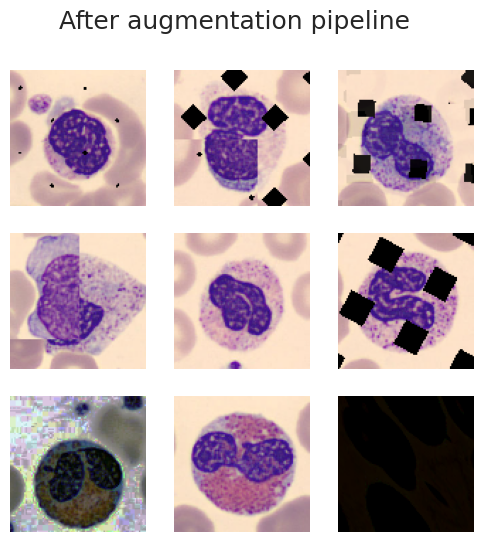

In [8]:
# Get a standard set of image augmentation policies
rand_aug = keras_cv.layers.RandAugment.get_standard_policy(
        value_range=(0,255),
        magnitude=1,
        magnitude_stddev=0.3
    )

# Remove specific types of augmentation layers from this list (Solarization and RandomColorDegeneration)
rand_aug = [layer for layer in rand_aug if
            not isinstance(layer, keras_cv.layers.Solarization)
            and not isinstance(layer,keras_cv.layers.RandomColorDegeneration)]

# Creation of a random image augmentation pipeline
rand_aug = keras_cv.layers.RandomAugmentationPipeline(
    layers = rand_aug, augmentations_per_image=AUG_PER_IMAGE, rate=RATE
)

# Creation of three  instances of three different data augmentation techniques
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()
grid_mask = keras_cv.layers.GridMask()

# Function used to apply the augmentation to the images
def preprocess(images, labels):
    samples = {"images": images, "labels": labels}

    if tf.random.uniform(()) > 0.5:
        samples = rand_aug(samples)
    else:
        if tf.random.uniform(()) > RATE:
            samples = grid_mask(samples)

        if tf.random.uniform(()) > RATE:
            samples = cut_mix(samples)

        if tf.random.uniform(()) > RATE:
            samples = mix_up(samples)

    return samples["images"], samples["labels"]

# Cleaned dataset loading with a split in three datasets: training, validation, and test
X, y = utils.load_cleaned_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.2, val_size=0.2)

# Converts numpy arrays into tensorflow dataset applying automatic prefetching and setting batch size
def convert_into_dataset(X, y, split=""):
    X = tf.cast(X, tf.float32)
    y = tf.one_hot(y, NUM_CLASSES)
    y = tf.cast(y, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if split == "train":
        dataset = dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    else:
        dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Actual conversion of the numpy datasets into tensorflow datasets
train_data = convert_into_dataset(X_train, y_train, split="train")
val_data = convert_into_dataset(X_val, y_val)

# Augmentation and expansion the training, validation, and test datasets
for _ in range(MULT):
    new_train_data = train_data.map(preprocess, num_parallel_calls=AUTOTUNE)
    new_train_data = new_train_data.concatenate(new_train_data)
    new_val_data = val_data.map(preprocess, num_parallel_calls=AUTOTUNE)
    new_val_data = new_val_data.concatenate(new_val_data)

# Duplication of the datasets
train_data = new_train_data
val_data = new_val_data

# Function for the dataset visualization
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6))
    plt.suptitle(title, fontsize=18)
    for i, (images, labels) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

# Visualize the dataset
visualize_dataset(new_train_data, title="After augmentation pipeline")

## Model Implementation

In [9]:
# Importing of the model EfficientNetV2B3 without dense layers
efficientNet = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
efficientNet.trainable = False

In [10]:
# Definition of the model
def build_model():
    # The input layer takes 96x96 RGB images
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Addition of EfficientNetV2B3 to the model
    x = efficientNet(input_layer)

    # GAP, dropout, dense, and ReLU layers for the top of the network
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dense(512)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(256)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dense(128)(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Dropout(0.5)(x)

    # Dense layer as output
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', dtype='float32', name='Output')(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [11]:
# Definition of the leraning rate for Adam optimizer
LR = 5e-4

In [12]:
# Model contruction
model = build_model()

# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(optimizer=tfk.optimizers.Adam(LR),
              loss=tfk.losses.CategoricalCrossentropy(), #Sparse since we are not one-hot-encoding (no difference)
              metrics=['accuracy'])

# Print model details
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 3, 3, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,882,822 (52.96 MB)

 Trainable params: 952,200 (3.63 MB)

 Non-trainable params: 12,930,622 (49.33 MB)

## Training

In [13]:
# Parameters used for training
EPOCHS = 10
PATIENCE = 3

In [14]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
callbacks = [early_stopping]

In [15]:
# Actual training of the model with the given parameters
history = model.fit(train_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=val_data).history

Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 100s 262ms/step - accuracy: 0.3727 - loss: 1.7192 - val_accuracy: 0.6081 - val_loss: 1.1702
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 34s 139ms/step - accuracy: 0.5562 - loss: 1.3051 - val_accuracy: 0.6702 - val_loss: 1.0132
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.5986 - loss: 1.2456 - val_accuracy: 0.6706 - val_loss: 1.0448
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.6217 - loss: 1.1665 - val_accuracy: 0.6495 - val_loss: 1.1016
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.6300 - loss: 1.1331 - val_accuracy: 0.6770 - val_loss: 1.0296


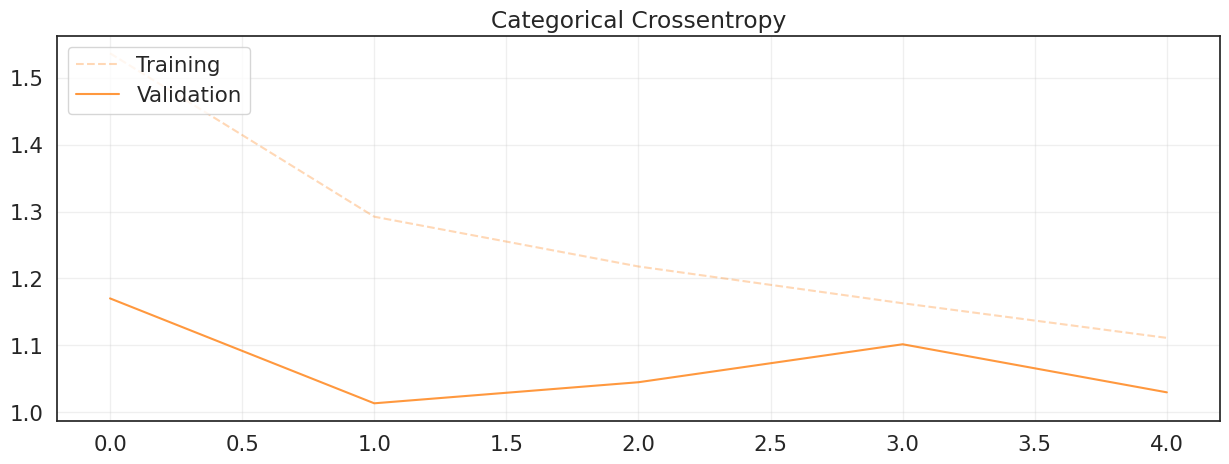

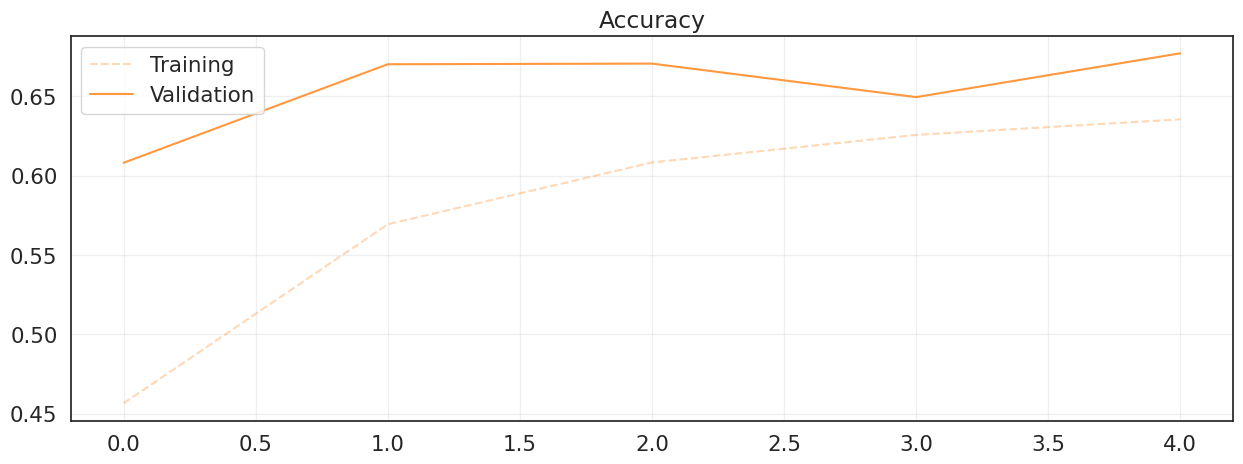

In [16]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(history)

## Save

In [17]:
# Saving the model for testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"efficientnetv2b3_again_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1/models
Saving efficientnetv2b3_again_67.7.keras
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1
Model Saved


## Fine-Tuning


In [18]:
# Parameter for the model name
model_name = 'efficientnetv2-b3'

In [19]:
# Setting all the parameters of the network as trainable
model.get_layer(model_name).trainable = True

# Setting all layers as not trainable since there is no necessity to train again all layers
for layer in model.get_layer(model_name).layers:
    layer.trainable = False

# Setting only Convolutional as trainable
for i, layer in enumerate(model.get_layer(model_name).layers):
    if isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.SeparableConv2D) or isinstance(layer, tfkl.DepthwiseConv2D):
        layer.trainable = True

# Setting a depth to which we freeze the training (0 to 60)
FREEZE_DEPTH = 60
for layer in model.get_layer(model_name).layers[:FREEZE_DEPTH]:
    layer.trainable = False

# Print model details
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 3, 3, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,787,224 (60.22 MB)

 Trainable params: 13,183,470 (50.29 MB)

 Non-trainable params: 699,352 (2.67 MB)

 Optimizer params: 1,904,402 (7.26 MB)

In [20]:
# Parameters used for Fine Tuning
FT_LEARNING_RATE = 1e-4

In [21]:
# Model compilation with Adam as optimizer and sparse categorical crossentropy as loss function
model.compile(optimizer=tfk.optimizers.Adam(FT_LEARNING_RATE),
                loss=tfk.losses.CategoricalCrossentropy(), #Sparse since we are not one-hot-encoding (no difference)
                metrics=['accuracy'])

In [22]:
# Parameters used for training
EPOCHS = 150
PATIENCE = 20

In [23]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
callbacks = [early_stopping]

In [24]:
# Actual Fine Tuning of the model with the given parameters
finetuned_history = model.fit(train_data,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              callbacks=callbacks,
                              validation_data= val_data ).history

Epoch 1/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 135s 309ms/step - accuracy: 0.6783 - loss: 1.0454 - val_accuracy: 0.7935 - val_loss: 0.7536
Epoch 2/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.7802 - loss: 0.8572 - val_accuracy: 0.8230 - val_loss: 0.6741
Epoch 3/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.8117 - loss: 0.7061 - val_accuracy: 0.8328 - val_loss: 0.6464
Epoch 4/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.8120 - loss: 0.7220 - val_accuracy: 0.8591 - val_loss: 0.5397
Epoch 5/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.8294 - loss: 0.6599 - val_accuracy: 0.8495 - val_loss: 0.5913
Epoch 6/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.8451 - loss: 0.6163 - val_accuracy: 0.8528 - val_loss: 0.5506
Epoch 7/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.8411 - loss: 0.6465 - val_accuracy: 0.8604 - val_loss: 0.5121
Epoch 8/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.8393 

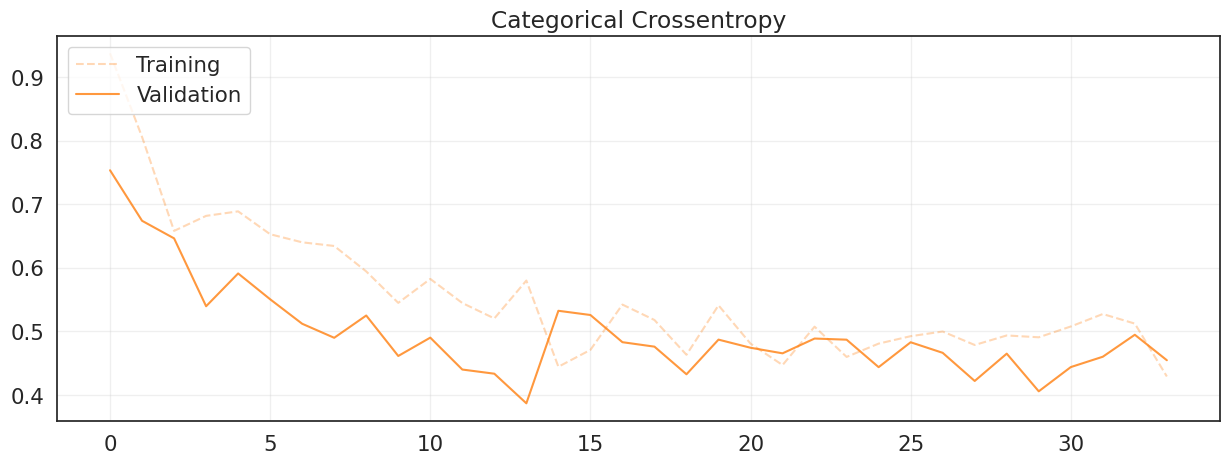

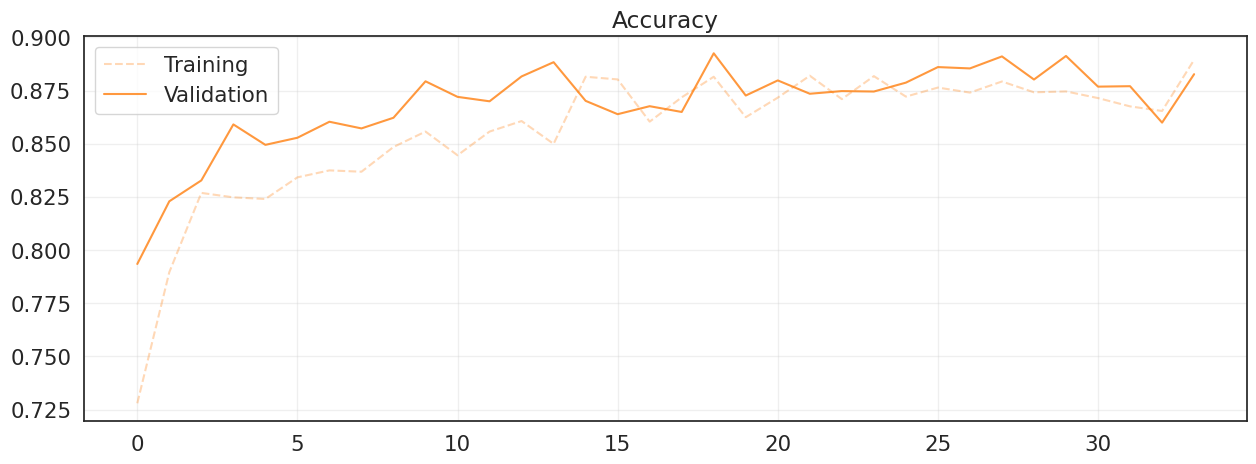

In [25]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(finetuned_history)

In [26]:
# Saving the model for testing and submission
accuracy = round(max(finetuned_history['val_accuracy'])* 100, 2)
model_name = f"efficientnetv2b3_again_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1/models
Saving efficientnetv2b3_again_89.26.keras
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [27]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [28]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.982
Precision score over the test set: 0.9822
Recall score over the test set: 0.982
F1 score over the test set: 0.982
